In [1]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import scipy.stats as stats

# from libwise import presetutils, plotutils

from ps_eor import psutil, datacube, pspec, fgfit, fitutil, simu, obssimu

import GPy

import matplotlib as mpl
mpl.use('Agg')

mpl.rcParams['image.cmap'] = 'Spectral_r'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['axes.grid'] = True

# presetutils.set_rc_preset('notebook')
%matplotlib inline


Bad key text.latex.preview in file /home/flo/Software/conda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/flo/Software/conda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/flo/Software/conda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95       # when a jpeg is saved, the defau

# Gaussian Process Regression: theory and practice

### Non-parametric modeling with GPR

A Gaussian process is a probability distribution over functions. It constitutes the generalization of the Gaussian distribution of random variables or vectors, into the space of functions. A Gaussian process $f \sim \mathcal{GP}\left(m, k\right)$ is fully defined by its mean $m$ and covariance function (also called "kernel") $k$ so that any points $x_1,...x_n$ in some continuous input space is associated with a normally distributed random variable,

\begin{equation}
f(x_1),...,f(x_n) \sim \mathcal{N}\left((m(x_1),...,m(x_n)), K(x_1, ...,x_n)\right)
\end{equation}

The distribution of a Gaussian process is the joint distribution of all those random variables.

In Gaussian Process Regression, we are seeking a function $f(x)$ that would model our noisy observation $y = f(x) + \epsilon$, with $\epsilon$ Gaussian noise with variance $\sigma_n^2$, observed at the data points $x$. Given the Gaussian Process prior $\mathcal{GP}\left(0, k\right)$, the joint density distribution of the observations $y$ and function values $f(x')$ at data points $x'$ is,

\begin{equation}
\left[ \begin{array}{c} y \\ f' \end{array}\right] \sim  \mathcal{N}\left( \left[\begin{array}{c} 0 \\ 0 \end{array}\right], \left[ \begin{array}{cc} K(x, x) + \sigma_n^2 I & K(x,x') \\ K(x',x) & K(x',x') \end{array}  \right] \right). \end{equation}

Conditioning the joint prior distribution on the observations, we obtain the joint posterior distribution of our model at data points $x'$,

\begin{equation}
f'|x, y \sim \mathcal{N}\left(\overline{f'}, \mathrm{cov}(f')\right)
\end{equation}

with:

\begin{align}
\overline{f'} &= K(x', x)\left[K(x, x) + \sigma_n^2 I\right]^{-1} y\\
\mathrm{cov}(f') &= K(x', x') - K(x', x)\left[K(x, x) + \sigma_n^2 I\right]^{-1}K(x, x').
\end{align}

The function values $f'$ can then be sampled from the joint posterior distributing by evaluating the mean and covariance matrix above.

Gaussian process regression can be see as non-parametric fitting method in which we can assign prior information on the model in a form of a covariance function. 

### Covariance functions

A crucial aspect of GPR modeling is on the selection of the right covariance function as it will determine the kind of structure that the GP will be able to model. A common class of covariance function is the Matern class. It is defined by:

\begin{equation}
k_{\mathrm{Matern}}(r) = \frac{2^{1 - \nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu}r}{l}\right)^{\nu}
K_{\nu}\left(\frac{\sqrt{2\nu}r}{l}\right)
\end{equation}

Functions obtain with this class of kernel are at least $\nu$-times differentiable. The kernel is also parametrized by the 'hyperparameter' $l$, the characteristic length-scale, which can be think of as the scale at which the signal start to decolorate. Special case of this class are obtained setting $\nu$ to infinity, in which case we obtain a square-exponential kernel, and by setting $\nu$ to $1 / 2$, in which case we obtain an exponential kernel.

### Covariance function selection and optimization

Model selection in the context of Gaussian Process Regression is a two fold problem. It corresponds on making a first choice on the kind of covariance function that could model our data, and then optimizing the 'hyperparameters' of this covariance function. Both can be done in a Bayesian sense, selecting the model that maximize the Evidence, also called the marginal-likelihood which is the integral of the likelihood times the prior:

\begin{equation}
p(y|x, \theta) = \int{p(y|f ,x, \theta)p(f|x, \theta)df},
\end{equation}

with $\theta$ the hyperparameters of the covariance function $K$. Under a Gaussian data model, we can integrate over $f$ analytically yielding the log-marginal-likelihood (LML)

\begin{equation}
\mathrm{log}\,p(y |x, \theta) = -\frac{1}{2}y^\intercal (K + \sigma_n^2 I)^{-1} y 
- \frac{1}{2} \mathrm{log}\,|K + \sigma_n^2 I| - \frac{n}{2} \mathrm{log}\,2\pi
\end{equation}

Selecting the $\theta$ that would maximize the LML is an optimization problem. Because the covariance function is defined analytically, it is trivial to compute the partial derivatives of the marginal likelihood with respect to the hyperparameters, which allow the use of efficient gradient-based optimization algorithm.

### GPR for EoR detection

In the context of EoR detection, we are interested in modeling our observations $y$ by a foreground, an EoR and a noise component:

\begin{equation}
y = f_{\mathrm{fg}}(x) + f_{\mathrm{eor}}(x) + \epsilon
\end{equation}

To separate the foreground from the 21 cm signal, we can exploit there different frequency behavior: the 21 cm signal is expected to be uncorrelated on scales of ~ 1 MHz, while the foregrounds are expected to be smooth. The covariance function of our GPR model can then be composed of a foreground covariance function $K_{\mathrm{fg}}$ and an EoR covariance function $K_{\mathrm{eor}}$,

\begin{equation}
K = K_{\mathrm{fg}} + K_{\mathrm{eor}} 
\end{equation}

The goal of including explicitly an EoR component is not so much to model it but to isolate its covariance contribution from the covariance of the foregrounds. An exhaustive model is also necessary to insure accurate estimation of the error covariance matrix.

The choice of covariance function for the 21 cm signal can be selected by determining the typical covariance matrix from EoR simulations. We plot below the covariance matrix of a 21 cm fast signal compared to Matern covariance functions of different $\nu$ and $l$. For this particular simulation the EoR signal can be model using an exponential ($\nu = 1 /2$) kernel of length-scale 0.5 MHz.

In [4]:
def get_cov_r(cov_matrix, dx):
    n = cov_matrix.shape[0]
    a, b = np.indices((n, n))

    r = abs(a - np.arange(n))
    r_bins = np.arange(-0.5, r.max() + 1.5)
    cov_m, _, _ = pspec.stats.binned_statistic(r.flatten(), cov_matrix.flatten(), 'mean', r_bins)
    rb = dx * (r_bins[:-1] + 0.5) #* 1e-6

    return rb, cov_m / cov_m[0]

def get_samples(x, m, kern):
    return np.random.multivariate_normal(np.zeros_like(x), kern.K(x[:, None], x[:, None]), m).T


Text(0.5, 1.0, 'Matern covariance functions for different\nvalues of nu and length-scale,\ncompared to the covariance of a 21 cm EoR signal')

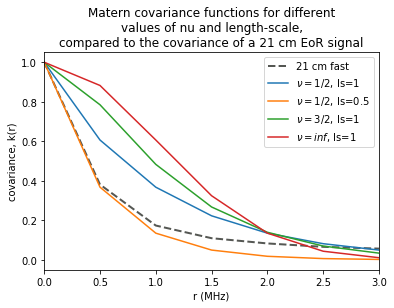

In [5]:
eor_cov_matrix = np.load('data/cov_matrix_eor_120-145.npy')

dx = 0.5
x = dx * np.arange(70)
samples = get_samples(x, 1000, GPy.kern.Matern32(1, lengthscale=1))
mat32_cov = np.cov(samples)

bins, eor_cov = get_cov_r(eor_cov_matrix, dx)
plt.plot(bins, eor_cov, lw=2, c=psutil.black, ls='--', label='21 cm fast')
plt.plot(bins, GPy.kern.Exponential(1).K_of_r(bins / 1), label='$\\nu = 1/2$, ls=1')
plt.plot(bins, GPy.kern.Exponential(1).K_of_r(bins / 0.5), label='$\\nu = 1/2$, ls=0.5')
plt.plot(bins, GPy.kern.Matern32(1).K_of_r(bins / 1.), label='$\\nu = 3/2$, ls=1')
plt.plot(bins, GPy.kern.RBF(1).K_of_r(bins / 1.), label='$\\nu = inf$, ls=1')

plt.xlim(0, 3)
plt.xlabel('r (MHz)')
plt.ylabel('covariance, k(r)')
plt.legend()
plt.title('Matern covariance functions for different\nvalues of nu and length-scale,\ncompared to the covariance of a 21 cm EoR signal')

The foregrounds need to be modeled by a smoother function. The square-exponential ($\nu = \inf$) suffer of a strong smoothness which might be unrealistic for modeling physical processes. Better alternatives may be a Matern kernel with $\nu = 5/2$ or $\nu = 3/2$. Ultimately, the choice of the foregrounds covariance function will be driven by the data in a Bayesian sense, by selecting the one which maximize the evidence.

Because of the weak power of the EoR signal compare to the FG and noise, finding the correct hyper-parameters of the EoR component would be close to impossible if this was done on each mode individually. The trick here is to optimize the LML for the full set of visibilities. This way it is possible to perform deeper modeling, reaching the level of the EoR.

After optimization of the GPR model, we retrieve the foregrounds part of the model:

\begin{align}
\overline{f_{\mathrm{fg}}} &= K_{\mathrm{fg}}(x, x)\left[K(x, x) + \sigma_n^2 I\right]^{-1} y\\
\mathrm{cov}(f_{\mathrm{fg}}) &= K_{\mathrm{fg}}(x, x) - K_{\mathrm{fg}}(x, x)\left[K(x, x) + \sigma_n^2 I\right]^{-1}K_{\mathrm{fg}}(x, x).
\end{align}

We are interested in estimating the residual after foregrounds subtracted,

\begin{align}
y_{\mathrm{res}} &= y - f_{\mathrm{fg}} \\
&=y - (\overline{f_{\mathrm{fg}}} + f^{\mathrm{err}}_{\mathrm{fg}})
\end{align}

The foregrounds fitting error $f^{\mathrm{err}}_{\mathrm{fg}}$ can not be determined, however we have an estimate of its statistics from the covariance of the posterior distribution of the foregrounds Gaussian Process, $\mathrm{cov}(f_{\mathrm{fg}})$. If one is interested in estimating a map of the foregrounds or the residual, this error covariance matrix may be used to compute uncertainty on the maps. If one is interested in computing the power spectra of the foregrounds or the residual, the error covariance matrix must be included. If $\mathrm{Ps}(y_{\mathrm{res}})$ represents the power spectra of the residual, it can be estimated by:

\begin{equation}
\mathrm{Ps}(y_{\mathrm{res}}) = \mathrm{Ps}(y - \overline{f_{\mathrm{fg}}}) + \mathrm{Ps}(f^{\mathrm{err}}_{\mathrm{fg}})
\end{equation}

with $\mathrm{Ps}(f^{\mathrm{err}}_{\mathrm{fg}})$, the power spectra of the foregrounds fitting error which may be estimated analytically, or through Monte-Carlo simulation, from the error covariance matrix $\mathrm{cov}(f_{\mathrm{fg}})$.

## A simple experiment

One of the main difficulty in modeling the foregrounds is the contamination due to primary beam and PSF chromatic effects, ionosphere, side lobes due to imperfect calibration... Those effects result in frequency fluctuations on scale of a few MHz. We will demonstrate that is possible with GPR to differentiate those contaminants from the EoR signal, as long as there frequency covariances are different.

We first create a data cube composed of a noise, FG and EoR part.

In [187]:
dx = 0.2
fmhz = np.arange(120, 140, dx)
freqs = fmhz * 1e6

nx = ny = 400.
fov = np.radians(8)
res = fov / nx

ls_fg = 4
ls_eor = 0.5
var_noise = 1e-6
var_fg = 1e2 * var_noise
var_eor = 0.04 * var_noise

kern_fg = GPy.kern.RBF(1, lengthscale=ls_fg, variance=var_fg)
kern_eor = GPy.kern.Exponential(1, lengthscale=ls_eor, variance=var_eor)

uu, vv, _ = psutil.get_ungrid_vis_idx((nx, ny), res, 50, 250)

m = len(uu)
y_eor = simu.get_gp_samples(fmhz, m, kern_eor)
y_fg = simu.get_gp_samples(fmhz, m, kern_fg)
noise = np.sqrt(var_noise) * (np.random.randn(len(fmhz), m) + 1j * np.random.randn(len(fmhz), m))
y = y_fg + y_eor + noise

shape = (int(nx), int(ny))
meta = datacube.ImageMetaData.from_res(res, shape)
meta.wcs.wcs.cdelt[2] = dx * 1e6

eor_cube = datacube.CartDataCube(y_eor, uu, vv, freqs, meta)
fg_cube = datacube.CartDataCube(y_fg, uu, vv, freqs, meta)
noise_cube = datacube.CartDataCube(noise, uu, vv, freqs, meta)

obs_cube = datacube.CartDataCube(y, uu, vv, freqs, meta)

eor_bin_list = pspec.EorBinList(freqs)
eor_bin_list.add_freq(1, 122.5, 137.5, 120, 140)

eor = eor_bin_list.get(1)

el = 2 * np.pi * np.arange(50, 250, 5)
ps_conf = pspec.PowerSpectraConfig(el)

pb = datacube.LofarHBAPrimaryBeam()
ps_gen = pspec.PowerSpectraCart(eor, ps_conf, pb)

We plot below the 3D power spectra of the different components of our observed signal. While the contaminants have power order of magnitude lower than the physical sky foregrounds, they spread to larger $k_{\parallel}$ and hence there power is still important up to $k \sim 0.2 - 0.3$. 

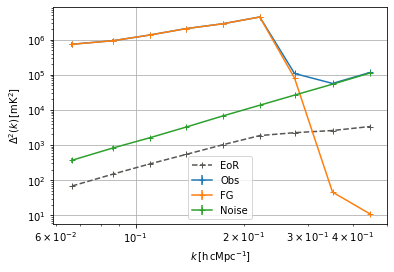

In [188]:
kbins = np.logspace(np.log10(ps_gen.kmin), np.log10(0.5), 10)
ps_gen.get_ps3d(kbins, obs_cube).plot(label='Obs')
ps_gen.get_ps3d(kbins, fg_cube).plot(label='FG', ax=plt.gca())
ps_gen.get_ps3d(kbins, noise_cube).plot(plt.gca(), label='Noise')
ps_gen.get_ps3d(kbins, eor_cube).plot(plt.gca(), label='EoR', nsigma=0, ls='--', c=psutil.black)
plt.legend()

We set up the GPR using a Matern kernel with $\nu = 5/2$ covariance function for the FG, and and an exponential kernel for the EoR. The hyper-parameters of this model is then optimized by maximizing the LML.

In [154]:
gpr_config = fitutil.GprConfig()
gpr_config.r_mean = False
gpr_config.fg_kern = GPy.kern.RBF(1, name='fg_sky') 
gpr_config.fg_kern.lengthscale.constrain_bounded(1, 20)

gpr_config.eor_kern = GPy.kern.Exponential(1, name='eor_exp')
gpr_config.eor_kern.lengthscale.constrain_bounded(0.2, 1.4)

gpr_fit = fgfit.GprForegroundFit(gpr_config)

gpr_res = gpr_fit.run(eor.get_slice_fg(obs_cube), eor.get_slice_fg(noise_cube))

reconstraining parameters fg_sky.lengthscale
reconstraining parameters eor_exp.lengthscale


GPR: running GPR
GPR: fitted model:

Name : gp
Objective : -688867.6184539752
Number of Parameters : 104
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                      |                   value  |  constraints  |  priors
  sum.fg_sky.variance      |       1.038407020771584  |      +ve      |        
  sum.fg_sky.lengthscale   |       3.990267664733588  |   1.0,20.0    |        
  sum.eor_exp.variance     |  0.00040077293060754917  |      +ve      |        
  sum.eor_exp.lengthscale  |     0.43208059059525433  |    0.2,1.4    |        
  het_Gauss.variance       |                (100, 1)  |   +ve fixed   |        


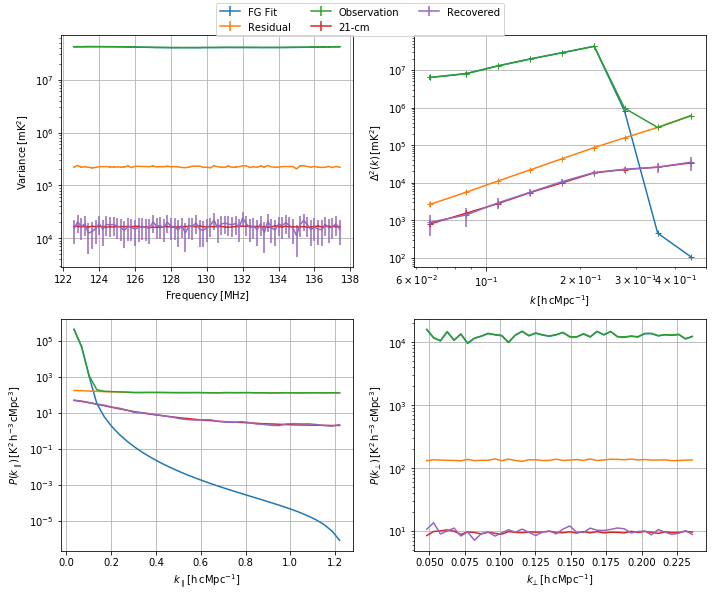

In [155]:
fp = pspec.FourPanelPsResults(ps_gen, kbins)
fp.add_cube(gpr_res.fit, 'FG Fit')
fp.add_cube(gpr_res.sub, 'Residual')
fp.add_cube(obs_cube, 'Observation')
fp.add_cube(eor_cube, '21-cm')
fp.add_cube_ps_diff(gpr_res.sub, noise_cube, 'Recovered')
fp.done()

The result of the optimization, as shown above, clearly show that we detected an EoR signal with length-scale and power close to our input signal. Our job is not done yet however: the complexity of the foregrounds will inevitably result in important model error on large frequency scale (corresponding to low $k_{\parallel}$). We plot below in red the 2D power spectra of the error which is made on the foregrounds model. The GPR estimated power spectra error obtained from $\mathrm{cov}(f_{\mathrm{fg}})$ (green dashed lines) shows a good agreement with the actual error, and allow an accurate estimation of the power spectra of the residual (orange dashed line).

In [164]:
total_time_hour = 1000
min_weight = 10
simu_lofar = obssimu.LofarHBA(freqs, 90, 0, 12, timeres=50)

uu_m, vv_m, _ = simu_lofar.simu_uv()
oversampling_factor = 1 / (obs_cube.meta.res * simu_lofar.umax)
uv_simu = simu_lofar.simu_gridded_uv(uu_m, vv_m, np.degrees(obs_cube.meta.theta_fov), 
                                     oversampling_factor=oversampling_factor)
noise_cube = uv_simu.weights.simulate_noise(uv_simu.get_sefd(), total_time_hour * 3600, hermitian=False)
noise_cube.filter_min_weight(min_weight, replace=True)


Simulating UV coverage ...
Number of elements: 62
Number of baselines: 1891
Discarding 31 intra-baselines
 Progress: 864 / 864 (Total: 2.69 s) Progress: 283 / 864 (ETA: 18:27:02) Progress: 405 / 864 (ETA: 18:27:01) Progress: 580 / 864 (ETA: 18:27:02) Progress: 627 / 864 (ETA: 18:27:02)  
Gridding UV coverage ...
 Progress: 100 / 100 (Total: 0.52 s) 
Filtering 0 visibilities (0.00 %)


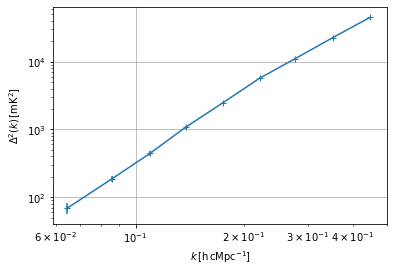

In [165]:
ps_gen.get_ps3d(kbins, noise_cube).plot()

In [166]:
obs_cube = fg_cube + eor_cube + noise_cube

gpr_res = gpr_fit.run(eor.get_slice_fg(obs_cube), eor.get_slice_fg(noise_cube))

GPR: running GPR
GPR: fitted model:

Name : gp
Objective : -1364459.0530024623
Number of Parameters : 104
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                      |                   value  |  constraints  |  priors
  sum.fg_sky.variance      |      1.0698363457905968  |      +ve      |        
  sum.fg_sky.lengthscale   |      3.9925933392263784  |   1.0,20.0    |        
  sum.eor_exp.variance     |  0.00042742091285064964  |      +ve      |        
  sum.eor_exp.lengthscale  |     0.49603612182360624  |    0.2,1.4    |        
  het_Gauss.variance       |                (100, 1)  |   +ve fixed   |        


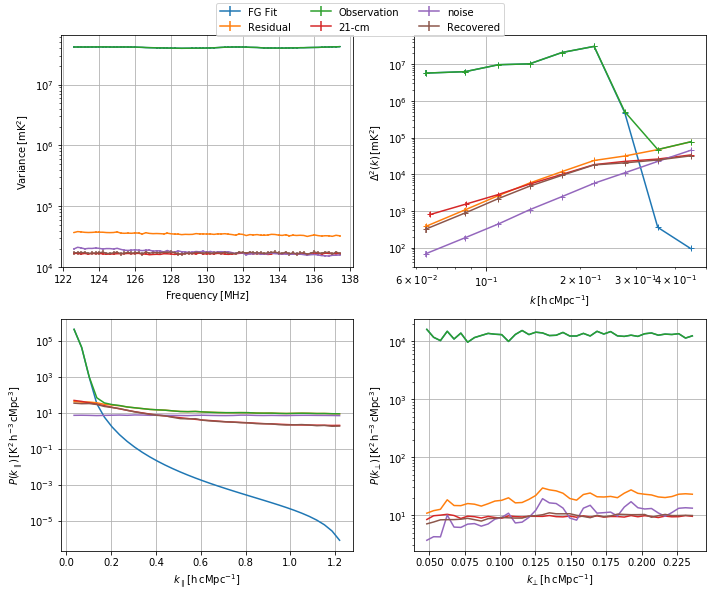

In [167]:
fp = pspec.FourPanelPsResults(ps_gen, kbins)
fp.add_cube(gpr_res.fit, 'FG Fit')
fp.add_cube(gpr_res.sub, 'Residual')
fp.add_cube(obs_cube, 'Observation')
fp.add_cube(eor_cube, '21-cm')
fp.add_cube(noise_cube, 'noise')
fp.add_cube_ps_diff(gpr_res.sub, noise_cube, 'Recovered')
fp.done()

In [183]:
dx = 0.2
fmhz = np.arange(120, 140, dx)
freqs = fmhz * 1e6

nx = ny = 400.
fov = np.radians(8)
res = fov / nx

ls_fg = 47.5
ls_mix = 2.97
ls_ex = 0.26
ls_eor = 0.5
var_noise = 2e-8
var_fg = 611 * var_noise
var_mix = 50.4 * var_noise
var_ex = 2.18 * var_noise
var_eor = 0.04 * var_noise

kern_fg = GPy.kern.RBF(1, lengthscale=ls_fg, variance=var_fg)
kern_mix = GPy.kern.Matern32(1, lengthscale=ls_mix, variance=var_mix)
kern_ex = GPy.kern.Matern52(1, lengthscale=ls_ex, variance=var_ex)
kern_eor = GPy.kern.Exponential(1, lengthscale=ls_eor, variance=var_eor)

uu, vv, _ = psutil.get_ungrid_vis_idx((nx, ny), res, 50, 250)

m = len(uu)
y_eor = simu.get_gp_samples(fmhz, m, kern_eor)
y_fg = simu.get_gp_samples(fmhz, m, kern_fg)
y_mix = simu.get_gp_samples(fmhz, m, kern_mix)
y_ex = simu.get_gp_samples(fmhz, m, kern_ex)
noise = np.sqrt(var_noise) * (np.random.randn(len(fmhz), m) + 1j * np.random.randn(len(fmhz), m))
y = y_fg + y_eor + noise + y_mix + y_ex

shape = (int(nx), int(ny))
meta = datacube.ImageMetaData.from_res(res, shape)
meta.wcs.wcs.cdelt[2] = dx * 1e6

eor_cube = datacube.CartDataCube(y_eor, uu, vv, freqs, meta)
fg_cube = datacube.CartDataCube(y_fg, uu, vv, freqs, meta)
mix_cube = datacube.CartDataCube(y_mix, uu, vv, freqs, meta)
ex_cube = datacube.CartDataCube(y_ex, uu, vv, freqs, meta)
noise_cube = datacube.CartDataCube(noise, uu, vv, freqs, meta)

obs_cube = datacube.CartDataCube(y, uu, vv, freqs, meta)

eor_bin_list = pspec.EorBinList(freqs)
eor_bin_list.add_freq(1, 122.5, 137.5, 120, 140)

eor = eor_bin_list.get(1)

el = 2 * np.pi * np.arange(50, 250, 5)
ps_conf = pspec.PowerSpectraConfig(el)

pb = datacube.LofarHBAPrimaryBeam()
ps_gen = pspec.PowerSpectraCart(eor, ps_conf, pb)

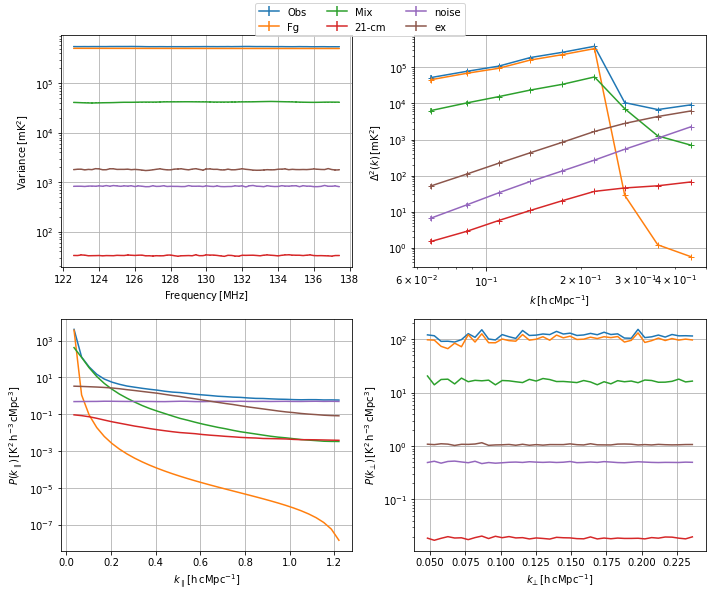

In [184]:
fp = pspec.FourPanelPsResults(ps_gen, kbins)
fp.add_cube(obs_cube, 'Obs')
fp.add_cube(fg_cube, 'Fg')
fp.add_cube(mix_cube, 'Mix')
fp.add_cube(eor_cube, '21-cm')
fp.add_cube(noise_cube, 'noise')
fp.add_cube(ex_cube, 'ex')
fp.done()

In [172]:
gpr_config = fitutil.GprConfig()
gpr_config.r_mean = False
gpr_config.fg_kern = GPy.kern.RBF(1, name='fg_sky')  + GPy.kern.Matern32(1, name='fg_mix')
gpr_config.fg_kern.fg_sky.lengthscale.constrain_bounded(10, 100)
gpr_config.fg_kern.fg_mix.lengthscale.constrain_bounded(1, 20)

gpr_config.eor_kern = GPy.kern.Exponential(1, name='eor_exp') + GPy.kern.Matern52(1, name='ex')
gpr_config.eor_kern.eor_exp.lengthscale.constrain_bounded(0.2, 1.4)
gpr_config.eor_kern.ex.lengthscale.constrain_bounded(0.1, 1)

gpr_fit = fgfit.GprForegroundFit(gpr_config)

gpr_res = gpr_fit.run(eor.get_slice_fg(obs_cube), eor.get_slice_fg(noise_cube))

reconstraining parameters sum.fg_sky.lengthscale
reconstraining parameters sum.fg_mix.lengthscale
reconstraining parameters sum.eor_exp.lengthscale
reconstraining parameters sum.ex.lengthscale


GPR: running GPR
GPR: fitted model:

Name : gp
Objective : -811703.156786607
Number of Parameters : 108
Number of Optimization Parameters : 8
Updates : True
Parameters:
  gp.                      |                  value  |  constraints  |  priors
  sum.fg_sky.variance      |     0.9437338240622358  |      +ve      |        
  sum.fg_sky.lengthscale   |      48.89275728552298  |  10.0,100.0   |        
  sum.fg_mix.variance      |    0.07504028336596656  |      +ve      |        
  sum.fg_mix.lengthscale   |        2.9573445010613  |   1.0,20.0    |        
  sum.eor_exp.variance     |  8.902937763935485e-06  |      +ve      |        
  sum.eor_exp.lengthscale  |     1.3998708907229505  |    0.2,1.4    |        
  sum.ex.variance          |  0.0033206435963377638  |      +ve      |        
  sum.ex.lengthscale       |      0.258422363724797  |    0.1,1.0    |        
  het_Gauss.variance       |               (100, 1)  |   +ve fixed   |        


If we now plot the 3D power spectra of the residual after the noise bias has been subtracted, we can recover the EoR signal.

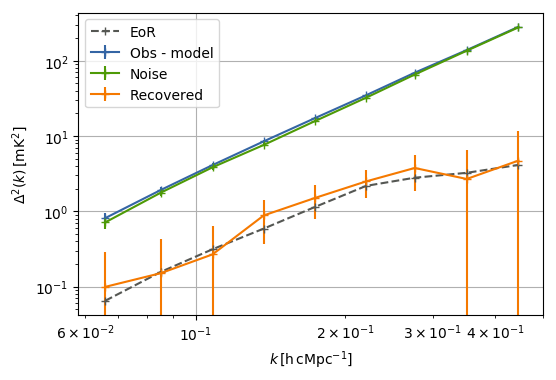

In [593]:
ps_gen.get_ps3d(kbins, gpr_res.sub).plot(plt.gca(), label='Obs - model')
ps_gen.get_ps3d(kbins, noise_cube).plot(plt.gca(), label='Noise')
ps_gen.get_ps3d(kbins, eor_cube).plot(plt.gca(), label='EoR', nsigma=0, ls='--', c=psutil.black)
(ps_gen.get_ps3d(kbins, gpr_res.sub) - ps_gen.get_ps3d(kbins, noise_cube)).plot(plt.gca(), label='Recovered', c=psutil.orange)
plt.legend()

### A real world example: LOFAR

Let's now try this method on actual LOFAR observations. We start by loading Stokes I & V of the L90490:

In [113]:
path = '/home/flo/data/NCP/nights'

def load_data(night, fov):
    print 'Loading %s with %s FoV' % (night, fov)
    ft_i_cube = datacube.CartDataCube.load(os.path.join(path, night, '%s_I_fov%s_u50-250.h5' % (night, fov)))
    ft_v_cube = datacube.CartDataCube.load(os.path.join(path, night, '%s_V_fov%s_u50-250.h5' % (night, fov)))

    outliers = psutil.get_outliers(ft_i_cube.freqs, ft_i_cube.data, threshold_n_rms=10)
    print 'Filtering outliers:', ft_i_cube.freqs[outliers] * 1e-6
    ft_i_cube.filter_outliers(outliers)
    ft_v_cube.filter_outliers(outliers)
    return ft_i_cube, ft_v_cube

night = 'L90490'
ft_i_cube, ft_v_cube = load_data(night, 3)

Loading L90490 with 3 FoV
Filtering outliers: [ 137.49848]


In [114]:
el = 2 * np.pi * (np.arange(50, 250, 10) + 5)
ps_conf = pspec.PowerSpectraConfig(el)

eor_bin_list = pspec.EorBinList(ft_i_cube.freqs)
eor_bin_list.add_freq(1, 122, 134, 120, 136)
eor_bin_list.add_freq(2, 134.3, 146.8, 133, 148)
eor_bin_list.add_freq(3, 144.5, 157.5, 143, 159)

eor_bin_name = 2
eor = eor_bin_list.get(eor_bin_name)

ps_gen = pspec.PowerSpectraCart(eor, ps_conf, datacube.LofarHBAPrimaryBeam())

We then set up the foreground fitter. To remove the smooth component of the foregrounds, a log-space bernsetin polynmial fit is performed before running GPR. The order is chosen as low as possible to limit the introduction of fitting error. We also run GPR on Stokes V so as to remove any potential foregrounds leakage.

In [115]:
reload(fgfit.fitutil)
reload(simu)

gpr_config_i = fitutil.GprConfig.load('data/gpr_config_i_single_night.parset')
gpr_config_v = fitutil.GprConfig.load('data/gpr_config_v_single_night.parset')

gpr_fit = fgfit.GprForegroundFit(gpr_config_i)
gpr_fit_v = fgfit.GprForegroundFit(gpr_config_v)

gpr_res = gpr_fit.run(eor.get_slice_fg(ft_i_cube), eor.get_slice_fg(ft_v_cube))
gpr_res_v = gpr_fit_v.run(eor.get_slice_fg(ft_v_cube), eor.get_slice_fg(ft_v_cube))

GPR: running pre power_bernstein (deg 2) fit
GPR: running GPR
GPR: fitted model:

Name : gp
Objective : 90734.9140488
Number of Parameters : 77
Number of Optimization Parameters : 4
Updates : True
Parameters:
  gp.                              |           value  |  constraints  |  priors
  sum.fg_Mat32.variance            |  0.511502508192  |      +ve      |        
  sum.fg_Mat32.lengthscale         |   6.04632973382  |   5.0,20.0    |        
  sum.eor_Exponential.variance     |  0.125919742545  |      +ve      |        
  sum.eor_Exponential.lengthscale  |  0.764622664853  |      +ve      |        
  het_Gauss.variance               |         (73, 1)  |   +ve fixed   |        
GPR: removing frequency mean
GPR: running GPR
GPR: fitted model:

Name : gp
Objective : 104470.125527
Number of Parameters : 76
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                       |              value  |  constraints  |  priors
  sum.fg_Mat32.variance     |    0.0190487

The optimized GPR model, after polynomial fitting, decompose the signal into a FG part with length-scale ~ 1.2 MHz accounting for half of the variance, and an EoR part with length-scale ~ 0.2 MHz accounting for about 10% of the variance. What is detected as EoR is of course not the cosmological signal but excess noise with very limited frequency correlation. This excess noise is what is remaining in the power spectra of the residual after noise bias is removed.

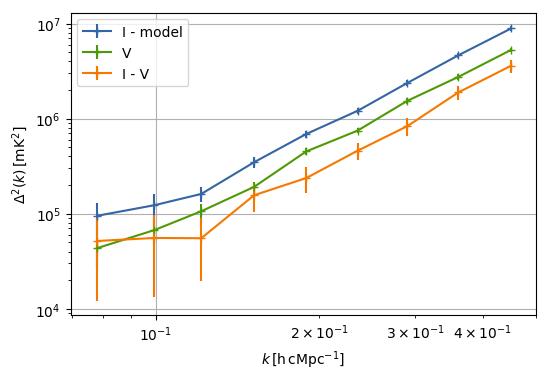

In [116]:
kbins = np.logspace(np.log10(ps_gen.kmin), np.log10(0.5), 10)
ps3d_sub = ps_gen.get_ps3d(kbins, gpr_res.sub)
ps3d_sub_v = ps_gen.get_ps3d(kbins, gpr_res_v.sub)

ps3d_sub.plot(label='I - model')
ps3d_sub_v.plot(ax=plt.gca(), label='V')
(ps3d_sub - ps3d_sub_v).plot(ax=plt.gca(), label='I - V', c=plotutils.orange)
plt.legend()

The FG is fluctuating on scale very similar to the cosmological signal, and leakage between the FG and EoR components is to be expected. The Leakage from FG to EoR will shows up as excess noise, as seen above. Leakage from EoR to FG can be estimated by injecting a simulated cosmological signal in Stokes I, and estimating what is remaining of this signal after foregrounds subtraction, by computing the difference of the residual power spectra with the injected signal and without it.

The test below injects an EoR signal with variance about 4% of the noise variance. After foregrounds subtraction we can estimate that about 60% of the EoR can be recovered, and so about 40% of the EoR signal leaked into the FG component. The level of leakage depends on the difference between the FG covariance function and the covariance of the cosmological signal. It can be limited by bounding the minimal allowed length-scale of the FG covariance function, or selecting a smoother covariance function, like a $\nu = 5 / 2$ Matern kernel, or a square exponential kernel. This will be however at the expense of increasing the leakage from the FG to the EoR component, and a compromise need to be found. It is to be noted here that 40 % of EoR signal is about the level of the sampling variance. So it might be an acceptable amount of leakage acceptable for a first detection.

An important point here is that the level of EoR to FG leakage dependent mainly on the FG covariance function and the EoR signal, so it can be estimated.

Progress: 1 / 1 
Progress: 1 / 1 
EoR recovered / input EoR (total power): 0.60


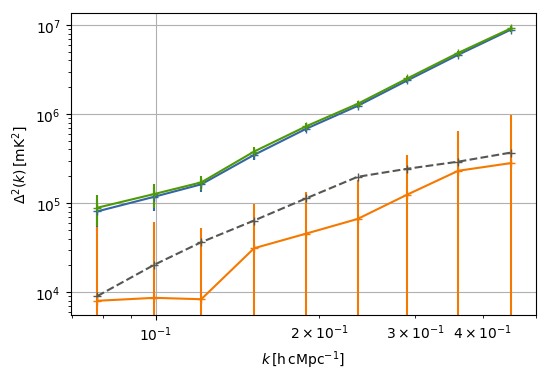

In [8]:
gpr_fit.config.verbose = False
gpr_fit_v.config.verbose = False
eor_simu = simu.SimuEorInjector(night, eor, gpr_fit, gpr_fit_v, ft_i_cube, ft_v_cube, eor_ls_range=(0.5, 0.5), 
                                eor_var_range=(0.04, 0.04))
eor_simu.run(1)
eor_simu.generate_ratios(ps_gen, kbins)

ps3d_eor = ps_gen.get_ps3d(kbins, eor_simu.data_eor_list[0])
ps3d_diff = (ps_gen.get_ps3d(kbins, eor_simu.data_sub_list[0]) - ps3d_sub)

plt.figure()
ps3d_sub.plot(label='I - model')
ps_gen.get_ps3d(kbins, eor_simu.data_sub_list[0]).plot(ax=plt.gca())
ps3d_eor.plot(ax=plt.gca(), ls='--', nsigma=0, c=plotutils.black)
ps3d_diff.plot(ax=plt.gca(), c=plotutils.orange)

print 'EoR recovered / input EoR (total power): %.2f' % (ps3d_diff.data.sum() / ps3d_eor.data.sum())

### Statistics on leakage and comparison with other FG subtraction method

We will now compute statistics on the EoR -> FG leakage. We do that for a total of 7 nights and 3 EoR bins, injecting simulated EoR signal with varying variance and length-scale. A total of 50 runs are performed for ech nights and EoR bins. For each runs we compute

\begin{equation}
r_{\mathrm{rec}} = \frac{\Delta_{\mathrm{rec}}^2(k)}{\Delta_{\mathrm{eor}}^2(k)},
\end{equation}

the ratio between recovered and input EoR, and 

\begin{equation}
r_\mathrm{IV} = \frac{\Delta_{\mathrm{res}}^2(k)} {\Delta_{\mathrm{V}}^2(k)}   \frac{\Delta_{\mathrm{V}}^2(1.25)} {\Delta_{\mathrm{res}}^2(1.25)}, 
\end{equation}

the ratio between the residual and the noise corrected from the excess noise which is estimated at hight $k$. $r_{\mathrm{rec}}$ evaluate the level of EoR -> FG leakage, while $r_{\mathrm{IV}}$ evaluate the level of FG -> EoR leakage. Ideally both should be as close to unity as possible.

We test the following foregrounds fitting setups:
- GPR with a Matern 3/2 as FG covariance function
- GPR with a Matern 5/2 as FG covariance function
- GMCA with 8 components
- Polynomial fit of order 4

In [74]:
kbins = np.logspace(np.log10(ps_gen.kmin), np.log10(0.5), 10)

def get_all_ratios(fitter_i, fitter_v):
    gpr_ratios = []
    for night in glob.glob('/home/flo/data/NCP/nights/L*'):
        night = os.path.basename(night)
        ft_i_cube, ft_v_cube = load_data(night, 3)

        eor_bin_list = pspec.EorBinList(ft_i_cube.freqs)
        eor_bin_list.add_freq(1, 122, 134, 120, 136)
        eor_bin_list.add_freq(2, 134.3, 146.8, 133, 148)
        eor_bin_list.add_freq(3, 144.5, 157.5, 143, 159)

        for eor_bin_name in [1, 2, 3]:
            print 'EoR bin:', eor_bin_name
            eor = eor_bin_list.get(eor_bin_name)
            ps_gen = pspec.PowerSpectraCart(eor, ps_conf, datacube.LofarHBAPrimaryBeam())

            eor_simu = simu.SimuEorInjector(night, eor, fitter_i, fitter_v, ft_i_cube, ft_v_cube)
            eor_simu.run(50)
            eor_simu.generate_ratios(ps_gen, kbins)
            gpr_ratios.append(eor_simu.ratios)
    return pd.concat(gpr_ratios)

all_gpr_mat32_ratios = get_all_ratios(gpr_fit, gpr_fit_v)

Same but with a Mat52 kernel for the FG
gpr_fit.config.fg_kern = GPy.kern.Matern52(1)
gpr_fit.config.fg_kern.lengthscale.constrain_bounded(5, 20)
gpr_fit_v.config.fg_kern = GPy.kern.Matern52(1)
gpr_fit_v.config.fg_kern.lengthscale.constrain_bounded(5, 20)
all_gpr_mat52_ratios = get_all_ratios(gpr_fit, gpr_fit_v)

gmca_fitter_i = fgfit.GmcaForegroundFit(8, mints=0.3)
gmca_fitter_v = fgfit.GmcaForegroundFit(1, mints=0.3)
all_gmca_ratios = get_all_ratios(gmca_fitter_i, gmca_fitter_v)

poly_fitter_i = fgfit.PolyForegroundFit(4, 'power_poly')
poly_fitter_v = fgfit.PolyForegroundFit(1, 'power_poly')
all_poly_ratios = get_all_ratios(poly_fitter_i, poly_fitter_v)

Loading L90490 with 3 FoV
Filtering outliers: [ 137.49848]
EoR bin: 1
Progress: 50 / 50 (ETA: 10:45:02)                                                
Progress: 50 / 50 (ETA: 10:45:03)                                                
EoR bin: 2
Progress: 50 / 50 (ETA: 10:45:05)                                                
Progress: 50 / 50 (ETA: 10:45:06)                                                
EoR bin: 3
Progress: 50 / 50 (ETA: 10:45:08)                                                
Progress: 50 / 50 (ETA: 10:45:10)                                                
Loading L196421 with 3 FoV
Filtering outliers: [ 137.49848]
EoR bin: 1
Progress: 50 / 50 (ETA: 10:45:11)                                                
Progress: 50 / 50 (ETA: 10:45:13)                                                
EoR bin: 2
Progress: 50 / 50 (ETA: 10:45:14)                                                
Progress: 50 / 50 (ETA: 10:45:16)                                                
EoR bi

In [2]:
# all_gmca_ratios.to_csv('data/all_gmca_ratios.csv', index=False)
# all_gpr_mat32_ratios.to_csv('data/all_gpr_mat32_ratios.csv', index=False)
# all_poly_ratios.to_csv('data/all_poly_ratios.csv', index=False)
# all_gpr_mat52_ratios.to_csv('data/all_gpr_mat52_ratios.csv', index=False)

all_gmca_ratios = pd.read_csv('data/all_gmca_ratios.csv')
all_poly_ratios = pd.read_csv('data/all_poly_ratios.csv')
all_gpr_mat32_ratios = pd.read_csv('data/all_gpr_mat32_ratios.csv')
all_gpr_mat52_ratios = pd.read_csv('data/all_gpr_mat52_ratios.csv')

We first compare GPR Mat32, GMCA and Poly

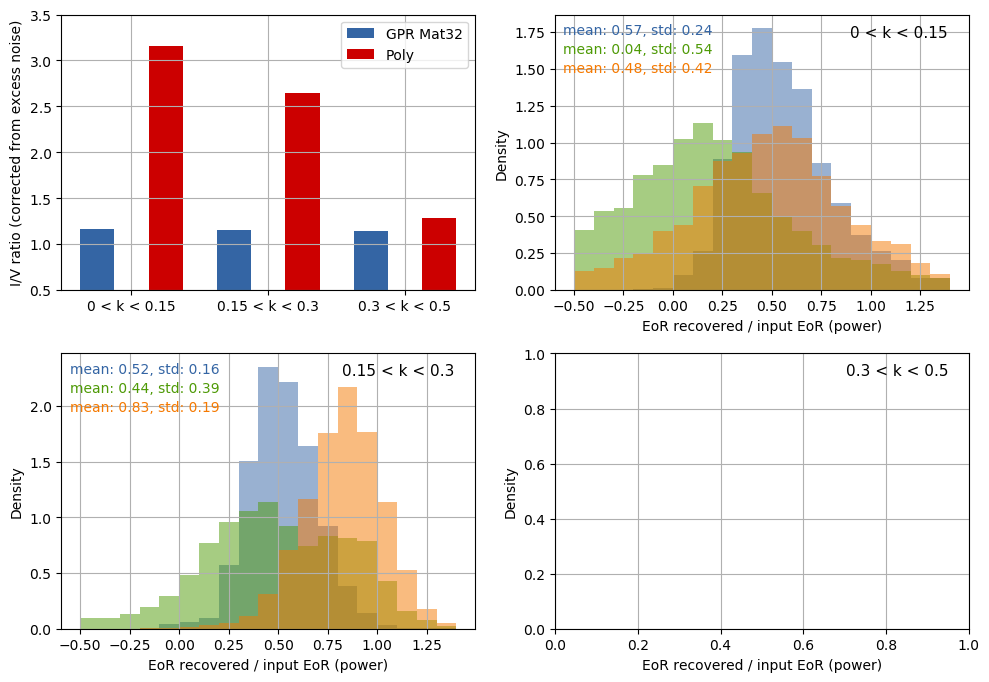

In [13]:
def get_ratios_stat(ax, all_ratios, kmin, kmax, text_y, color):
    idx = (all_ratios['k'] > kmin) & (all_ratios['k'] < kmax)
    
    std = (all_ratios[idx]['ratio'].quantile(0.84) - all_ratios[idx]['ratio'].quantile(0.16)) / 2.

    ax.hist(all_ratios[idx]['ratio'], bins=np.arange(-0.5, 1.5, 0.1), normed=True, alpha=0.5, color=color)
    text = 'mean: %.2f, std: %.2f' % (all_ratios[idx]['ratio'].mean(), std)
    ax.text(0.02, text_y, text, color=color, transform=ax.transAxes, ha='left')
    
def get_ratios_iv_stat(all_ratios, kbins):
    idx = (all_ratios['k'] > kmin) & (all_ratios['k'] < kmax)
    ratio_iv = all_ratios[idx]['ratio_iv'] / all_ratios[idx]['excess_noise']
    return ratio_iv.mean(), ratio_iv.std()

fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 7))

for yt, ax, ratios in zip((0.93, 0.86, 0.79), (psutil.blue, psutil.green, psutil.orange), (all_gpr_mat32_ratios, all_gmca_ratios, all_poly_ratios)):
    get_ratios_stat(ax1, ratios, 0, 0.15, yt, ax)
    get_ratios_stat(ax2, ratios, 0.15, 0.3, yt, ax)
#     get_ratios_stat(ax3, ratios, 0.3, 0.5, yt, ax)

ax1.text(0.95, 0.92, '0 < k < 0.15', transform=ax1.transAxes, ha='right', size=11)
ax2.text(0.95, 0.92, '0.15 < k < 0.3', transform=ax2.transAxes, ha='right', size=11)
ax3.text(0.95, 0.92, '0.3 < k < 0.5', transform=ax3.transAxes, ha='right', size=11)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('EoR recovered / input EoR (power)')
    ax.set_ylabel('Density')
    
kbins = [0, 0.15, 0.3, 0.6]
all_gpr_mat52_ratios['ratio_iv_corr'] = all_gpr_mat52_ratios['ratio_iv'] / all_gpr_mat52_ratios['excess_noise']
all_gpr_mat52_ratios['kbin'] = pd.cut(all_gpr_mat52_ratios['k'], kbins)
all_gpr_mat32_ratios['ratio_iv_corr'] = all_gpr_mat32_ratios['ratio_iv'] / all_gpr_mat32_ratios['excess_noise']
all_gpr_mat32_ratios['kbin'] = pd.cut(all_gpr_mat32_ratios['k'], kbins)
all_gmca_ratios['ratio_iv_corr'] = all_gmca_ratios['ratio_iv'] / all_gmca_ratios['excess_noise']
all_gmca_ratios['kbin'] = pd.cut(all_gmca_ratios['k'], kbins)
all_poly_ratios['ratio_iv_corr'] = all_poly_ratios['ratio_iv'] / all_poly_ratios['excess_noise']
all_poly_ratios['kbin'] = pd.cut(all_poly_ratios['k'], kbins)

ax4.bar(np.arange(3), all_gpr_mat32_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.blue, label='GPR Mat32')
ax4.bar(np.arange(3) + 0.25, all_gmca_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.green, label='GMCA')
ax4.bar(np.arange(3) + 0.5, all_poly_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.red, label='Poly')
ax4.set_xticks((0.25, 1.25, 2.25))
ax4.set_xticklabels(('0 < k < 0.15', '0.15 < k < 0.3', '0.3 < k < 0.5'))
ax4.set_ylabel('I/V ratio (corrected from excess noise)')
ax4.legend()
ax4.set_ylim(0.5, 3.5)

fig.tight_layout()
# fig.savefig(os.path.expanduser('~/stat_eor_injection_test_mat32.pdf'))

The upper left panel shows the performance of the different foreground fitting technique. For all $k$ range, GPR always perform better than any other methods.

The other panels show histogram of the $r_{\mathrm{rec}}$ ratio for the 3 different methods and for the 3 $k$ ranges.
- At $0 < k < 0.15$, GPR conserves in average 57% of the EoR signal, a similar level using the Poly fit method, performing however a lot better in terms of amount of foregrounds removed. Inversely, while GMCA achieve I/V ratio on par with GPR, most of the EoR signal is lost.
- At $0.15 < k < 0.3$, The Poly fit method performs the best in terms of $r_{\mathrm{rec}}$ ratio but still performs badly in I/V ratio. GPR still conserves in average about 50 % of the EoR signal and outmatch GMCA in terms of I/V ratio.
- At $0.3 < k < 0.5$, both Poly fit and GMCA keep most of EoR signal. GPR conserve in average about 80%, but is still actively removing foregrounds at those scales as can be attested from the lower I/V ratio.

We now compare GPR with the Matern 3/2 and Matern 5/2 covariance function.

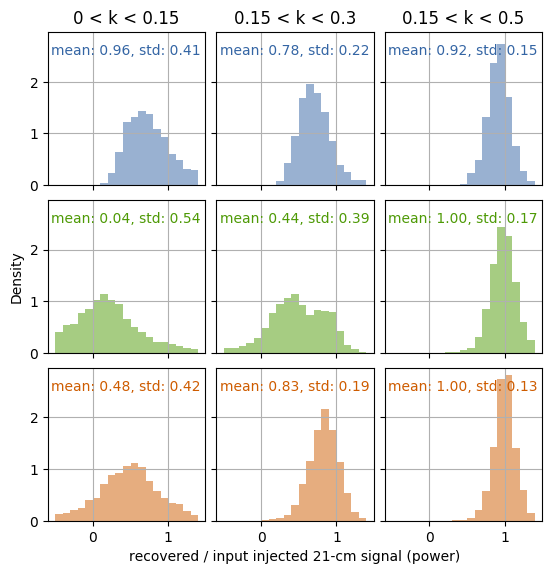

In [64]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(5.2, 5.2), sharey=True, sharex=True)

for yt, i_ax, c, ratios in zip((0.85, 0.85, 0.85), (0, 1, 2), (psutil.blue, psutil.green, psutil.dorange), (all_gpr_mat52_ratios, all_gmca_ratios, all_poly_ratios)):
    get_ratios_stat(axs[i_ax, 0], ratios, 0, 0.15, yt, c)
    get_ratios_stat(axs[i_ax, 1], ratios, 0.15, 0.3, yt, c)
    get_ratios_stat(axs[i_ax, 2], ratios, 0.3, 0.5, yt, c)
#     get_ratios_stat(ax, ratios, 0.15, 0.3, yt, c)

fig.tight_layout(pad=0.1)
lab1 = axs[2, 1].set_xlabel('recovered / input injected 21-cm signal (power)')
lab2 = axs[1, 0].set_ylabel('Density')

axs[0, 0].set_title('0 < k < 0.15')
axs[0, 1].set_title('0.15 < k < 0.3')
axs[0, 2].set_title('0.15 < k < 0.5')

# fig.savefig('/home/flo/injection_test.svg', bbox_extra_artists=(lab1, lab2), bbox_inches='tight')

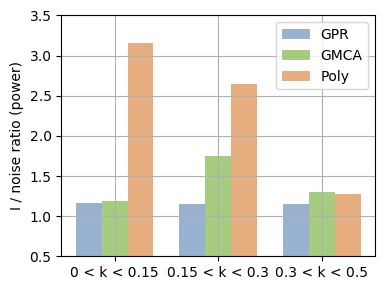

In [66]:
fig, ax4 = plt.subplots(ncols=1, nrows=1, figsize=(4, 3))

ax4.bar(np.arange(3), all_gpr_mat32_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.blue, label='GPR', alpha=0.5)
ax4.bar(np.arange(3) + 0.25, all_gmca_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.green, label='GMCA', alpha=0.5)
ax4.bar(np.arange(3) + 0.5, all_poly_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.25, 
        color=psutil.dorange, label='Poly', alpha=0.5)
ax4.set_xticks((0.25, 1.25, 2.25))
ax4.set_xticklabels(('0 < k < 0.15', '0.15 < k < 0.3', '0.3 < k < 0.5'))
ax4.set_ylabel('I / noise ratio (power)')
ax4.legend()
ax4.set_ylim(0.5, 3.5)

fig.tight_layout()


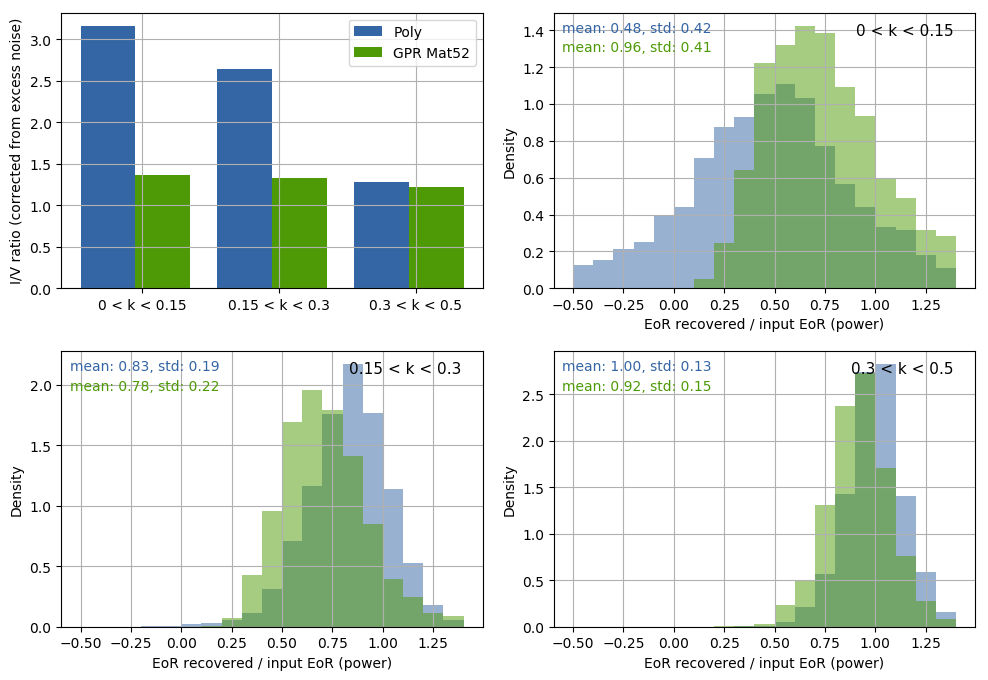

In [16]:
fig, ((ax4, ax1), (ax2, ax3)) = plt.subplots(ncols=2, nrows=2, figsize=(10, 7))

for yt, ax, ratios in zip((0.93, 0.86, 0.79), (psutil.blue, psutil.green, psutil.orange), (all_poly_ratios, all_gpr_mat52_ratios)):
    get_ratios_stat(ax1, ratios, 0, 0.15, yt, ax)
    get_ratios_stat(ax2, ratios, 0.15, 0.3, yt, ax)
    get_ratios_stat(ax3, ratios, 0.3, 0.5, yt, ax)

ax1.text(0.95, 0.92, '0 < k < 0.15', transform=ax1.transAxes, ha='right', size=11)
ax2.text(0.95, 0.92, '0.15 < k < 0.3', transform=ax2.transAxes, ha='right', size=11)
ax3.text(0.95, 0.92, '0.3 < k < 0.5', transform=ax3.transAxes, ha='right', size=11)

for ax in (ax1, ax2, ax3):
    ax.set_xlabel('EoR recovered / input EoR (power)')
    ax.set_ylabel('Density')
    
ax4.bar(np.arange(3), all_poly_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.4, 
        color=psutil.blue, label='Poly')
ax4.bar(np.arange(3) + 0.4, all_gpr_mat52_ratios.groupby('kbin')['ratio_iv_corr'].mean().values, width=0.4, 
        color=psutil.green, label='GPR Mat52')
ax4.set_xticks((0.25, 1.25, 2.25))
ax4.set_xticklabels(('0 < k < 0.15', '0.15 < k < 0.3', '0.3 < k < 0.5'))
ax4.set_ylabel('I/V ratio (corrected from excess noise)')
ax4.legend()
# ax4.set_ylim(0.5, 1.4)

fig.tight_layout()
# fig.savefig(os.path.expanduser('~/stat_eor_injection_test_mat52_vs_mat32.pdf'))

GPR with Matern 3/2 perform about 10% better in terms of I/V ratio, but about 20% worth in term of recovered over input EoR ratio.

0.0001768945227880146  is the resolution
Done


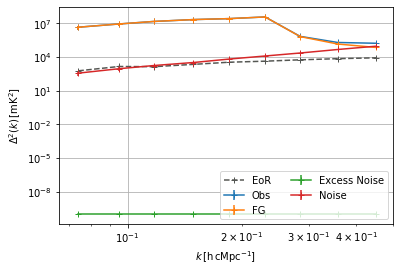

In [274]:
i_cube = datacube.CartDataCube.load('/home/flo/Downloads/9.026zeta3.000fesc3.000_Mmin0.100E+10_MminX0.100E+11_fx0.100E+01_sed3_al1.200tb.h5')
i_cube.filter_uvrange(50, 250)
# i_cube = 10 * i_cube
# dx = 0.2
# fmhz = np.arange(120, 140, dx)
# freqs = fmhz * 1e6

# nx = ny = 300.
# fov = np.radians(3.04)
# res = fov / nx

fmhz = i_cube.freqs *1e-6 
freqs = i_cube.freqs 
nx = ny = i_cube.meta.shape[0]
res = i_cube.meta.res #fov / nx
dx = np.diff(fmhz)[0]
print(res," is the resolution")

ls_sky = 47.5
ls_mix = 2.97
ls_ex = 0.26
var_noise = 1e-6 * (8 / 3.04) ** 2 ** 2
var_sky = 611 * var_noise
var_mix = 50.4 * var_noise
var_ex = 2.18 * var_noise
var_ex = 0
var_eor = 10 * var_noise
ls_eor = 0.8

kern_ex = GPy.kern.Matern52(1, lengthscale=ls_ex, variance=var_ex)
kern_sky = GPy.kern.RBF(1,lengthscale=ls_sky,variance=var_sky)
kern_mix = GPy.kern.Matern32(1, lengthscale=ls_mix, variance=var_mix)
kern_fg = kern_sky + kern_mix

kern_eor = GPy.kern.Exponential(1, lengthscale=ls_eor, variance=var_eor)

# uu, vv, _ = psutil.get_ungrid_vis_idx((nx, ny), res, 50, 250)

uu, vv = i_cube.uu, i_cube.vv
m = len(uu)

y_eor = i_cube.data
# y_eor = simu.get_gp_samples(fmhz, m, kern_eor)

y_fg = simu.get_gp_samples(fmhz, m, kern_fg)
y_ex = simu.get_gp_samples(fmhz, m, kern_ex)
noise = np.sqrt(var_noise) * (np.random.randn(len(fmhz), m) + np.random.randn(len(fmhz), m)* 1j)

y = y_fg + y_eor + y_ex + noise

shape = (int(nx), int(ny))
meta = datacube.ImageMetaData.from_res(res,shape)
meta.wcs.wcs.cdelt[2] = dx * 1e6

# eor_cube = datacube.CartDataCube(y_eor, uu, vv, freqs, meta)
eor_cube = i_cube
fg_cube = datacube.CartDataCube(y_fg, uu, vv, freqs, meta)
ex_cube = datacube.CartDataCube(y_ex, uu, vv, freqs, meta)
noise_cube = datacube.CartDataCube(noise, uu, vv, freqs, meta)
# print(noise_cube.data)
obs_cube = datacube.CartDataCube(y, uu, vv, freqs, meta)


eor_bin_list = pspec.EorBinList(freqs)
eor_bin_list.add_freq(1, np.mean(fmhz)-6.0, np.mean(fmhz)+6.0, min(fmhz), max(fmhz))

eor = eor_bin_list.get(1)

el = 2 * np.pi * np.arange(50, 250, 5)
ps_conf = pspec.PowerSpectraConfig(el)

pb = datacube.LofarHBAPrimaryBeam()
ps_gen = pspec.PowerSpectraCart(eor, ps_conf, pb)
print("Done")

kbins = np.logspace(np.log10(ps_gen.kmin), np.log10(0.5), 10)
ps_gen.get_ps3d(kbins, obs_cube).plot(label='Obs')
ps_gen.get_ps3d(kbins, fg_cube).plot(label='FG', ax=plt.gca())
ps_gen.get_ps3d(kbins, ex_cube).plot(label='Excess Noise', ax=plt.gca())
ps_gen.get_ps3d(kbins, noise_cube).plot(plt.gca(), label='Noise')
ps_gen.get_ps3d(kbins, eor_cube).plot(plt.gca(), label='EoR', nsigma=0, ls='--', c=psutil.black)
plt.legend(loc='lower right',ncol=2)

reconstraining parameters sum.fg_sky.lengthscale
reconstraining parameters sum.fg_mix.lengthscale
reconstraining parameters sum.eor_exp.lengthscale
reconstraining parameters sum.excess_noise.lengthscale


GPR: running GPR
GPR: fitted model:

Name : gp
Objective : -499795.18320135813
Number of Parameters : 308
Number of Optimization Parameters : 8
Updates : True
Parameters:
  gp.                           |                   value  |  constraints  |  priors
  sum.fg_sky.variance           |      0.9171274591991792  |      +ve      |        
  sum.fg_sky.lengthscale        |       46.07204441767046  |  10.0,100.0   |        
  sum.fg_mix.variance           |     0.07472831137395895  |      +ve      |        
  sum.fg_mix.lengthscale        |      2.9490562807122456  |   1.0,10.0    |        
  sum.eor_exp.variance          |  0.00010837007383669978  |      +ve      |        
  sum.eor_exp.lengthscale       |       1.188108265793624  |    0.1,1.2    |        
  sum.excess_noise.variance     |   8.960314660875105e-08  |      +ve      |        
  sum.excess_noise.lengthscale  |      0.7916727872788762  |    0.2,0.8    |        
  het_Gauss.variance            |                (300, 1)  |   +

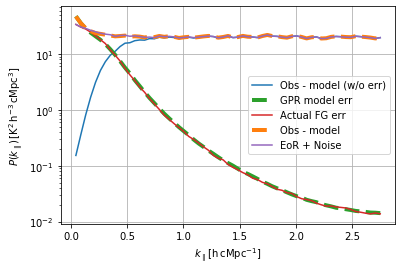

In [275]:
gpr_config = fitutil.GprConfig()
gpr_config.r_mean = False

gpr_config.fg_kern = GPy.kern.RBF(1, name='fg_sky') + GPy.kern.Matern32(1,name='fg_mix')
gpr_config.fg_kern.fg_sky.lengthscale.constrain_bounded(10, 100)
gpr_config.fg_kern.fg_mix.lengthscale.constrain_bounded(1, 10)

gpr_config.eor_kern = GPy.kern.Exponential(1, name='eor_exp') + GPy.kern.Matern32(1, name='excess_noise')
gpr_config.eor_kern.eor_exp.lengthscale.constrain_bounded(0.1,1.2)
gpr_config.eor_kern.excess_noise.lengthscale.constrain_bounded(0.2,0.8)# 1.2)

gpr_fit = fgfit.GprForegroundFit(gpr_config)
gpr_res = gpr_fit.run(eor.get_slice_fg(obs_cube),eor.get_slice_fg(noise_cube))

ps_gen.get_ps2d(gpr_res.sub, with_cov_err=False).plot_kpar(label='Obs - model (w/o err)',color='tab:blue')
ps_gen.get_ps2d_cov_err(gpr_res.sub).plot_kpar(ax=plt.gca(), ls='--', lw=4, label='GPR model err',color='tab:green')
ps_gen.get_ps2d(fg_cube.new_with_data(fg_cube.data - gpr_res.fit.data), with_cov_err=False).plot_kpar(ax=plt.gca(), label='Actual FG err',color='tab:red')
ps_gen.get_ps2d(gpr_res.sub).plot_kpar(ax=plt.gca(), ls='--', lw=4, label='Obs - model',color='tab:orange')
ps_gen.get_ps2d(eor_cube.new_with_data(eor_cube.data + noise_cube.data)).plot_kpar(ax=plt.gca(), label='EoR + Noise',color='tab:purple')
#plt.ylim(1e-4, 1e-1)
#plt.xlim(0, 0.4)
plt.legend()

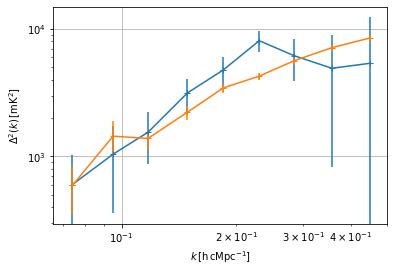

In [276]:
# ps_gen.get_ps3d(kbins, gpr_res.sub).plot()
ps_gen.get_ps3d_with_noise(kbins, gpr_res.sub, noise_cube).plot(ax=plt.gca())
ps_gen.get_ps3d(kbins, ex_cube + eor_cube).plot(ax=plt.gca())

In [2]:
import shlex, subprocess

shlex.split('du -hs /home/flo/Developpement/cd-eor/nenuprep-cd/data_NRI/nenufar-nri//ES01/2022/01/20220130_173300_20220131_050000_NCP_COSMIC_DAWN/L0/SB*.MS')

['du',
 '-hs',
 '/home/flo/Developpement/cd-eor/nenuprep-cd/data_NRI/nenufar-nri//ES01/2022/01/20220130_173300_20220131_050000_NCP_COSMIC_DAWN/L0/SB*.MS']

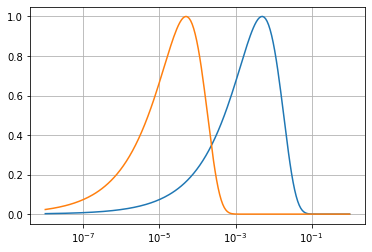

In [20]:
from GPy.core.parameterization.priors import Gamma, InverseGamma

x = np.logspace(-8, 0, 200)
plt.plot(x, Gamma(1.5, 1e2).pdf(x) / Gamma(1.5, 1e2).pdf(x).max())
plt.plot(x, Gamma(1.5, 1e4).pdf(x) / Gamma(1.5, 1e4).pdf(x).max())
# plt.plot(x, InverseGamma(1e-3).pdf(x))
plt.xscale('log')

In [16]:
np.log10(3)

0.47712125471966244